In [1]:
import numpy as np
import pandas as pd
from pandas import MultiIndex, Int16Dtype, Int64Index
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, mean_squared_error, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as ct
from lightgbm import LGBMClassifier, LGBMRegressor, Dataset, train
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from datetime import datetime as dt
from sklearn.feature_extraction import DictVectorizer
import category_encoders as ce
import shap
from Features import feature_process

C:\Users\MOHAPX\AppData\Local\Temp\ipykernel_13716\1438977336.py:3: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int16Dtype, Int64Index
C:\Users\MOHAPX\anaconda3\envs\gpu_\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
answer = pd.read_csv('Dataset/answer_file.csv', index_col=0)
test = pd.read_csv('Dataset/test_file.csv', index_col=0)
target = answer.TARGET
answer = answer.drop(['TARGET'], axis = 1)

In [3]:
#формируем выборку для контроля
data_train, data_valid, data_target, target_valid = train_test_split ( 
    answer, target, test_size = 0.2, random_state = 45)

In [4]:
cv = KFold(n_splits=5, random_state=100, shuffle=True)
param_dist = {"max_depth": [10, 20, None],                   
              "max_features": ['auto', 'sqrt'],          
              "min_samples_split": [10],     
              "bootstrap": [True],                
              "criterion": ["gini"]}           
clf = RandomForestClassifier(n_estimators=100)

In [5]:
random_search = GridSearchCV(clf, param_grid=param_dist, verbose = 2,
                                    cv=cv)

In [6]:
# Моделирование с использованием случайного леса
random_search.fit(data_train, data_target)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=auto, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=10; total time=   0.1s
[CV] END bootstrap=T

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [10, 20, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_split': [10]},
             verbose=2)

In [7]:
random_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 10}

In [8]:
random_search.best_score_

0.993505039193729

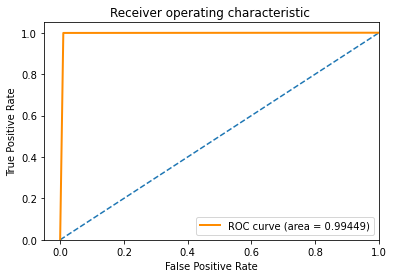

CPU times: total: 141 ms
Wall time: 146 ms


In [9]:
%%time
predict_forest = random_search.predict(data_valid)
auc_score = roc_auc_score(target_valid, predict_forest)
fpr, tpr, thresholds = roc_curve(target_valid, predict_forest)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, color="darkorange",
    lw=2,
    label="ROC curve (area = %0.5f)" % auc_score,
)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

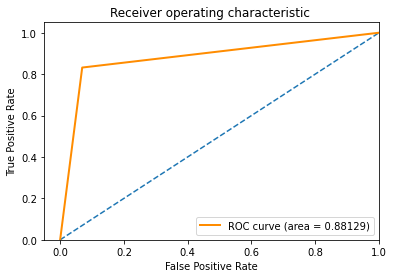

In [10]:
predict_forest_1 = random_search.predict(test[['cat', 'light', 'NN_cat_target', 'NN_cat_emb']])
auc_score = roc_auc_score(test.TARGET, predict_forest_1)
fpr, tpr, thresholds = roc_curve(test.TARGET, predict_forest_1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, color="darkorange",
    lw=2,
    label="ROC curve (area = %0.5f)" % auc_score,
)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

In [11]:
answer

cat  light  NN_cat_target  NN_cat_emb
0        1      1            1.0         1.0
1        0      0            0.0         0.0
2        1      0            0.0         1.0
3        1      0            1.0         1.0
4        1      1            1.0         1.0
...    ...    ...            ...         ...
11158    1      0            1.0         1.0
11159    1      1            1.0         1.0
11160    1      1            1.0         1.0
11161    1      1            1.0         1.0
11162    1      1            1.0         1.0

[11163 rows x 4 columns]